In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import random
import torch
import pickle

In [2]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

2.1.0+cu121
PyTorch version: None , CUDA version: 12.1


In [3]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
# disable interactive plots
# %matplotlib inline

# enable interactive plots
%matplotlib notebook

In [5]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [6]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True, normalize_factor=1):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)
        
        self.normalize_factor = normalize_factor

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        # x = self.node_encoder(data.x)
        if self.normalize_factor!=1:
            temp = data.x.clone().detach()
            temp[:,1] *= self.normalize_factor
            x = self.node_encoder(temp)
        else:
            x = self.node_encoder(data.x.clone().detach())

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

In [7]:
position_scale = 50.
feature_scale = 200.

In [8]:
# hitPos, hitType, layerZ, layerIndex, trackID

# event_file_name = '/home/jupyter-dmizera/GNN_3D/hitFile_small.pickle'
# mc_file_name = '/home/jupyter-dmizera/GNN_3D/MCtrackFile_small.pickle'

# event_file_name = '/home/jupyter-dmizera/GNN_3D/hitFile_medium.pickle'
# mc_file_name = '/home/jupyter-dmizera/GNN_3D/MCtrackFile_medium.pickle'

event_file_name = '/home/jupyter-dmizera/GNN_3D/hitFile_big.pickle'
mc_file_name = '/home/jupyter-dmizera/GNN_3D/MCtrackFile_big.pickle'

In [9]:
def readMuonE(noise_factor=0.50):

    with open(event_file_name, mode='rb') as events_file, open(mc_file_name, mode='rb') as mc_file:
        events = pickle.load(events_file)
        mc = pickle.load(mc_file)

        layers_zs =  [832.0, 843.7, 1141.0, 1146.0, 1252.7, 1266.0, 1467.4, 1479.6, 1960.0, 1973.0]
        num_layers = len(layers_zs)
        
        data_GNN_out = []
        data_tracks_out = [] # for saving indexes of hits of track for every event
        data_mc_out = []
        
        for event_index, event in enumerate(events):
            
            X = None
            track_hits = {'track_1': set(), 'track_2': set()} # for saving indexes of hits that belong to track 1 or 2
            
            for hit_index, hit in enumerate(event):
                if hit_index == 0:
                    X = np.array([[hit[0]*position_scale, # position
                                   hit[2], # z
                                   hit[3], # layer index
                                   hit[4]]]) # trackID
                    
                else:
                    X = np.append(X, np.array([[hit[0]*position_scale, # position
                                                hit[2], # z
                                                hit[3], # layer index
                                                hit[4]]]), axis=0) # trackID
                # add noise
                if random.random() < noise_factor:
                    position = random.uniform(hit[0] - 2.0, hit[0] + 2.0)
                        
                    X = np.append(X, np.array([[position*position_scale, # hit position
                                                hit[2], # z
                                                hit[3], # layer index
                                                -1]]), axis=0) # trackID
                    
                # save hit index to track
                track_hits['track_1'].add(hit_index) if int(hit[4]) == 1 else track_hits['track_2'].add(hit_index)
                                    
            e = []
            for layer in np.arange(num_layers - 1):
                for i in np.argwhere(X[:, 1] == layers_zs[layer]):
                    for j in np.argwhere(X[:, 1] == layers_zs[layer + 1]):
                        e.append([i, j])
            e = np.array(e).T.squeeze()

            try:
                # noise modified
                y = np.array([int(i[3] != -1 and j[3] != -1 and i[3] == j[3]) for i,j in zip(X[e[0]], X[e[1]])])

            except:
                # handle no edges created
                continue

            X = np.array([X[:,1], X[:,0]]).T / feature_scale # z, position
            
            data_event = Data(x = torch.from_numpy(X).float(),
                             edge_index = torch.from_numpy(e),
                             y = torch.from_numpy(y),
                             pid = torch.from_numpy(X[:,1]))

            data_GNN_out.append(data_event)
            data_tracks_out.append(track_hits)
            data_mc_out.append(mc[event_index])
        
        return data_GNN_out, data_tracks_out, data_mc_out

In [10]:
def plot_2D_graph(event, ylim=0.):

#     print(event)
#     print(event.x)
#     print(event.edge_index)
#     print(event.y)
#     print(event.pid)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
    
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')

    plt.scatter(x, y, c='k')
    
    if (ylim!=0):
        plt.ylim(-ylim, ylim)
    else:
        diff = 0.1*(max(y)-min(y))
        plt.ylim(min(y)-diff, max(y)+diff)

Fake / True =  3.6666666666666665
Training dataset (events):  79941
Test dataset (events):  19986


/home/jupyter-dmizera/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


<IPython.core.display.Javascript object>


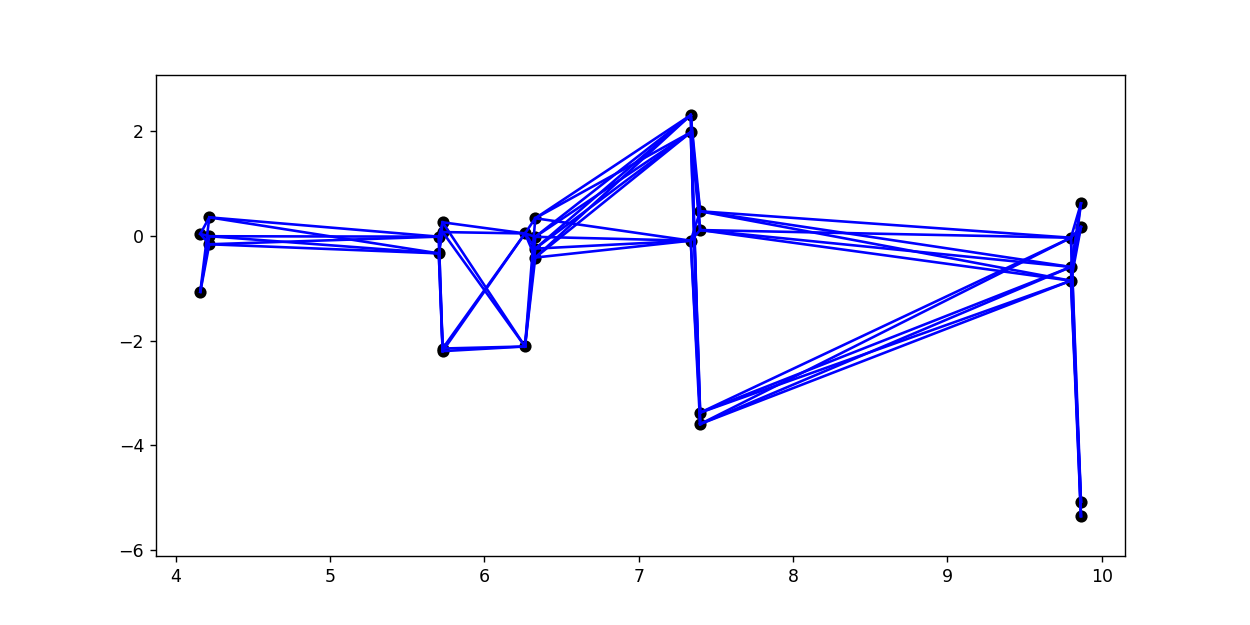

<IPython.core.display.Javascript object>


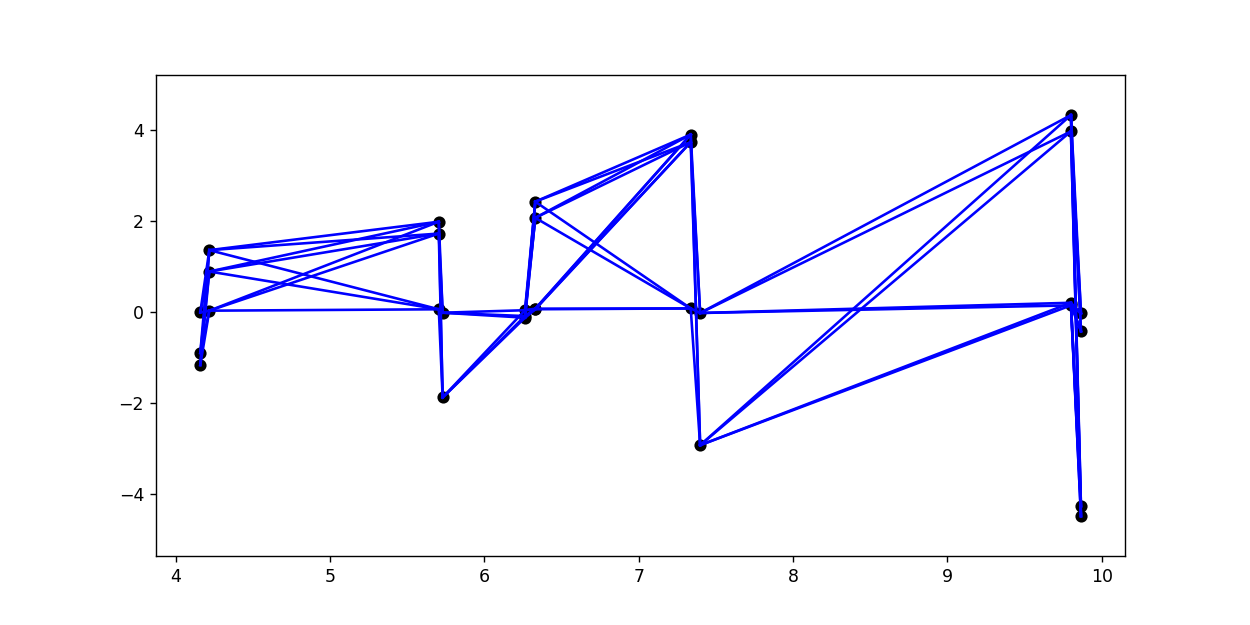

<IPython.core.display.Javascript object>


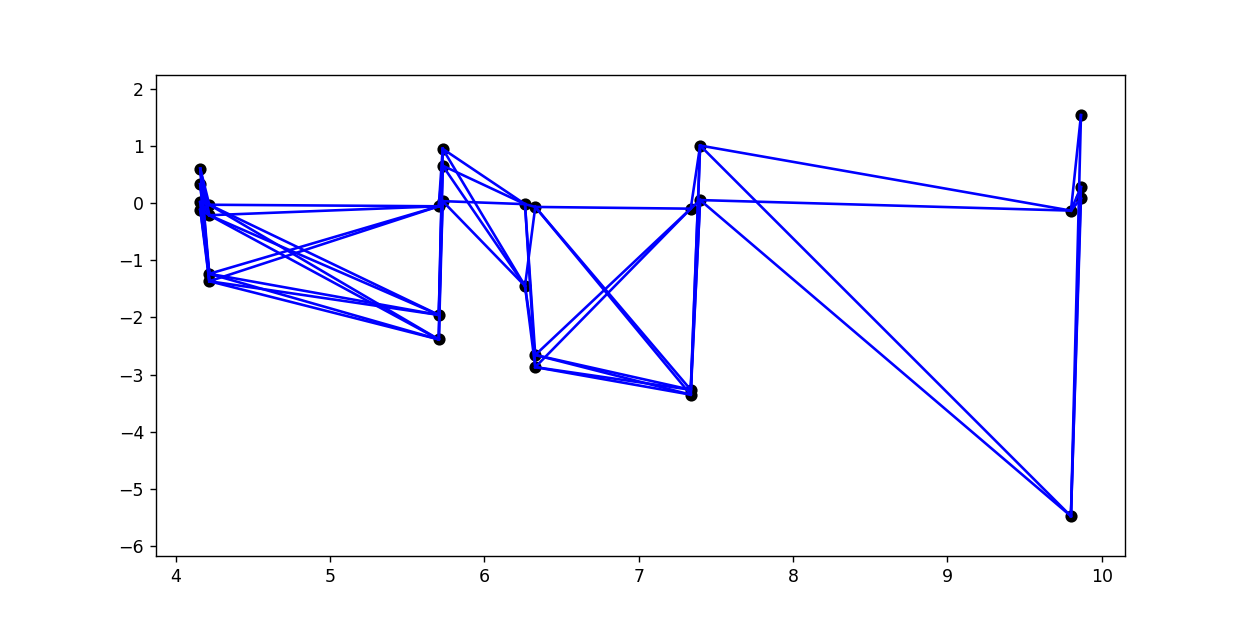

<IPython.core.display.Javascript object>


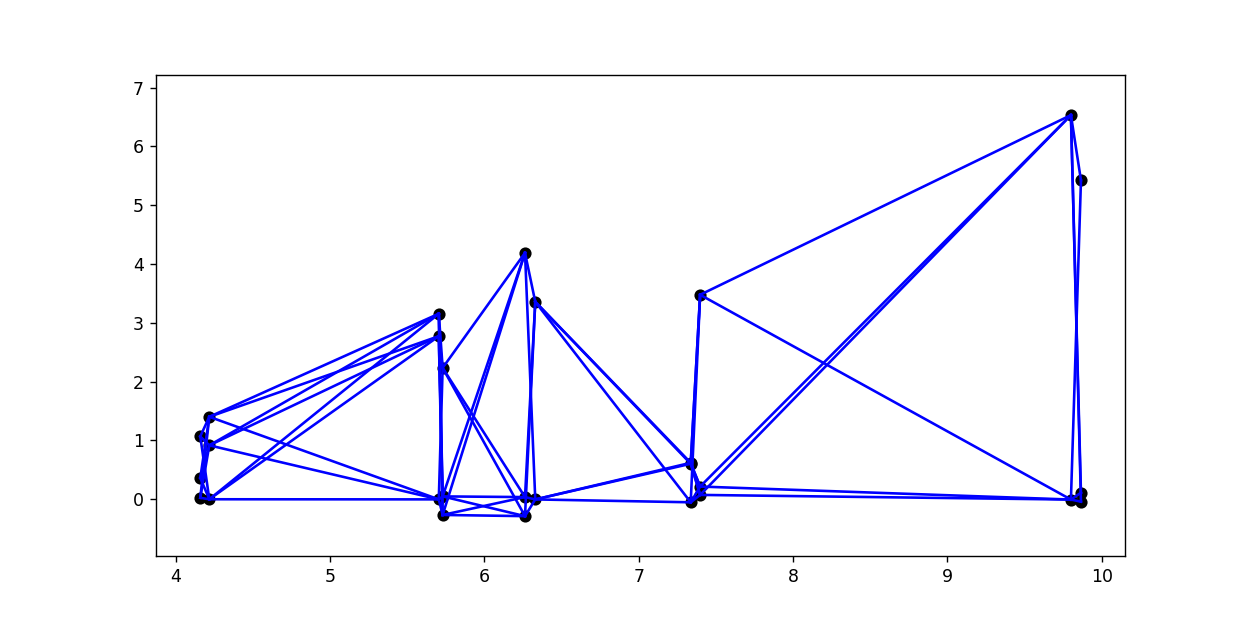

<IPython.core.display.Javascript object>


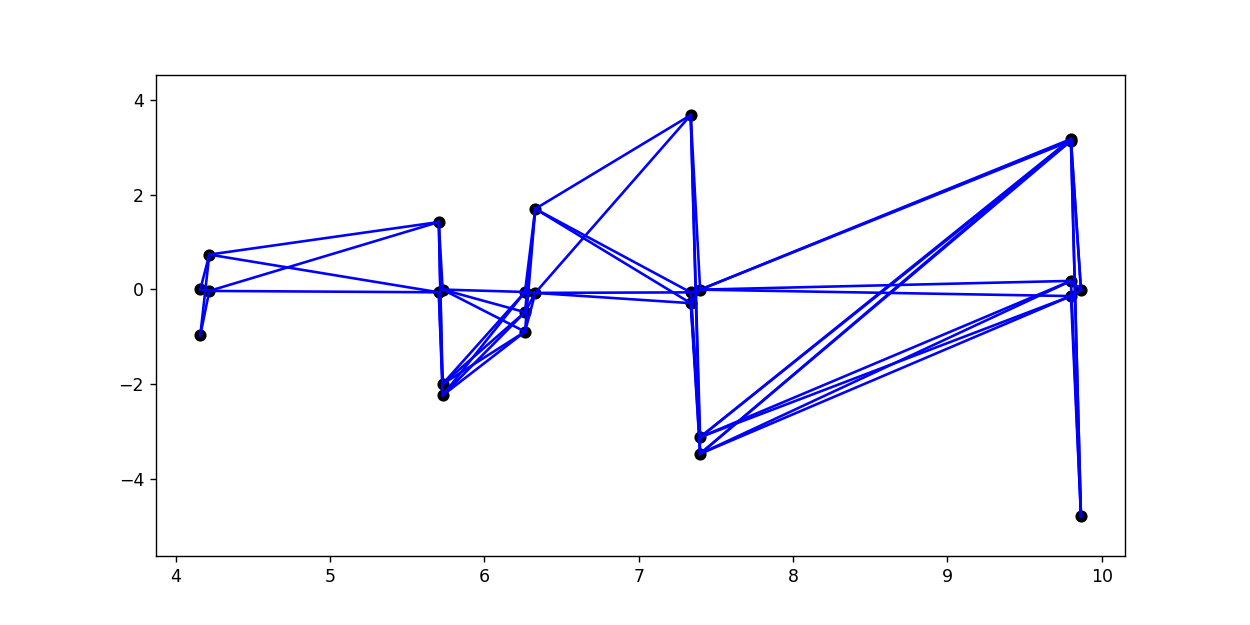

<IPython.core.display.Javascript object>


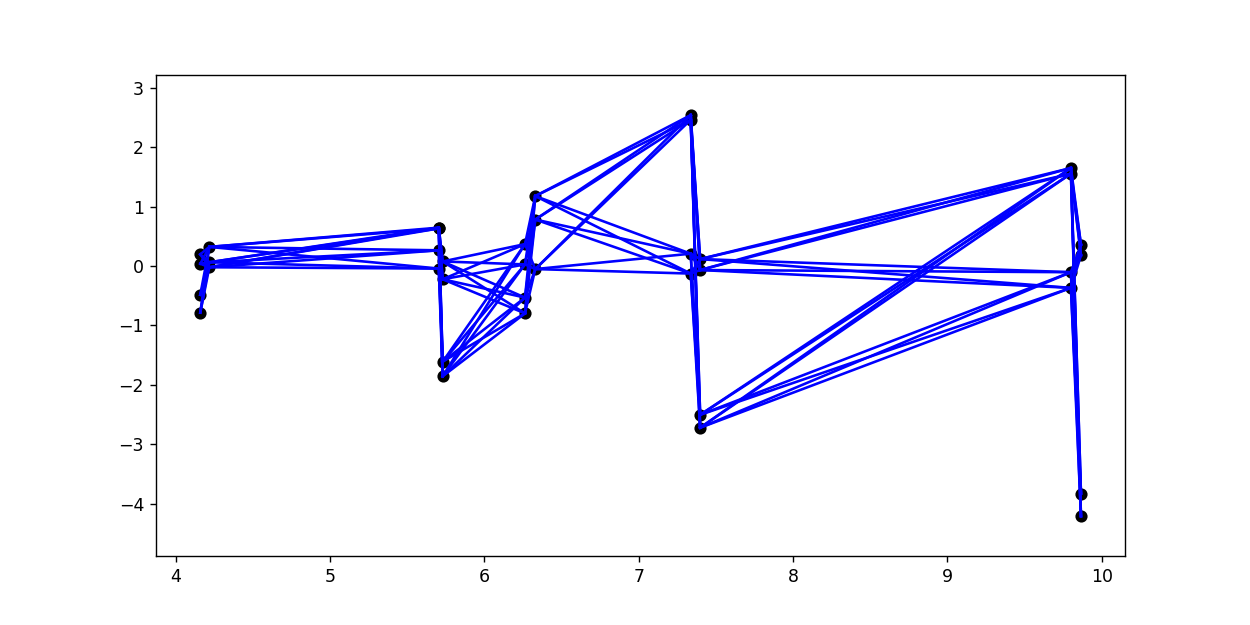

<IPython.core.display.Javascript object>


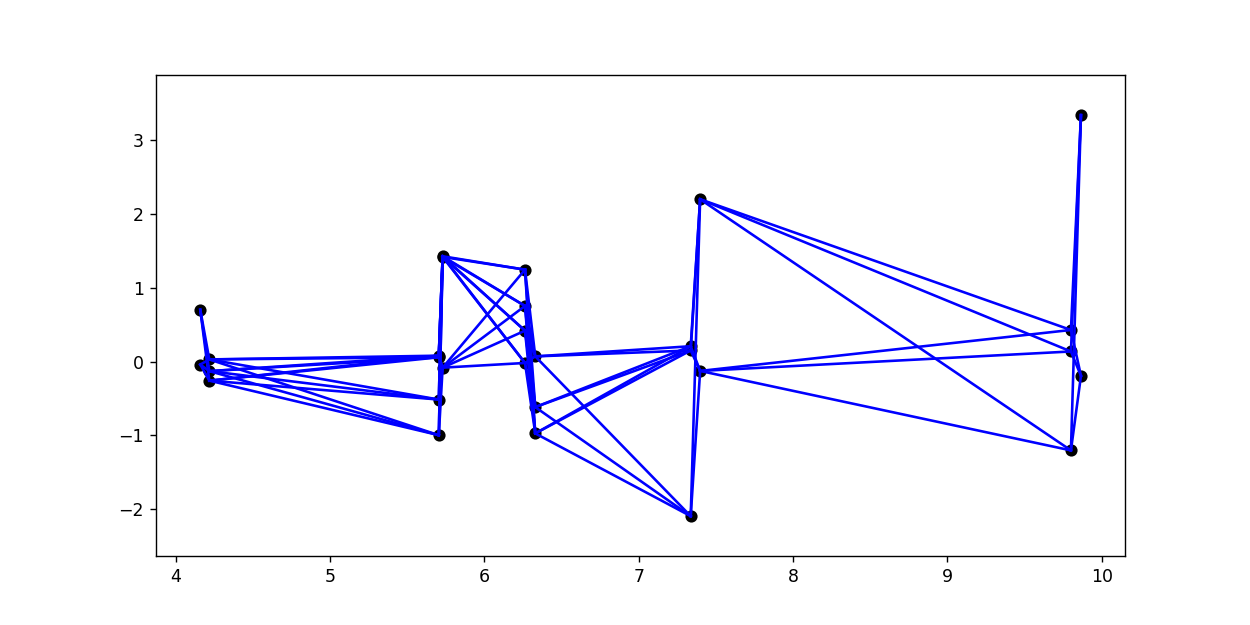

<IPython.core.display.Javascript object>


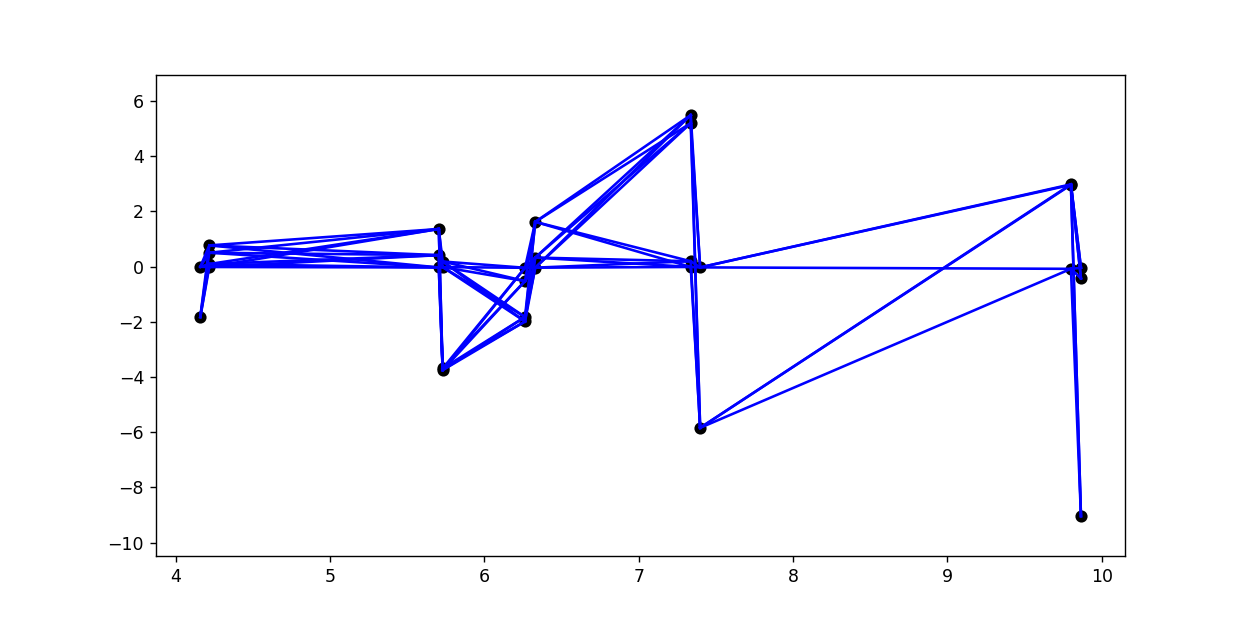

<IPython.core.display.Javascript object>


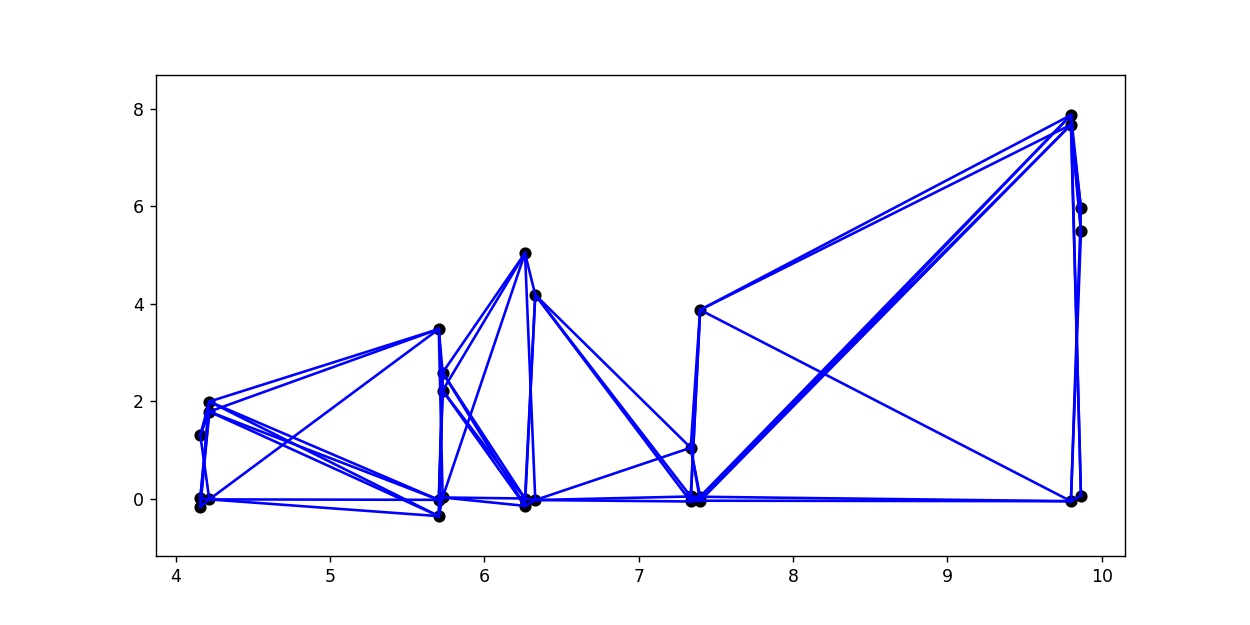

<IPython.core.display.Javascript object>


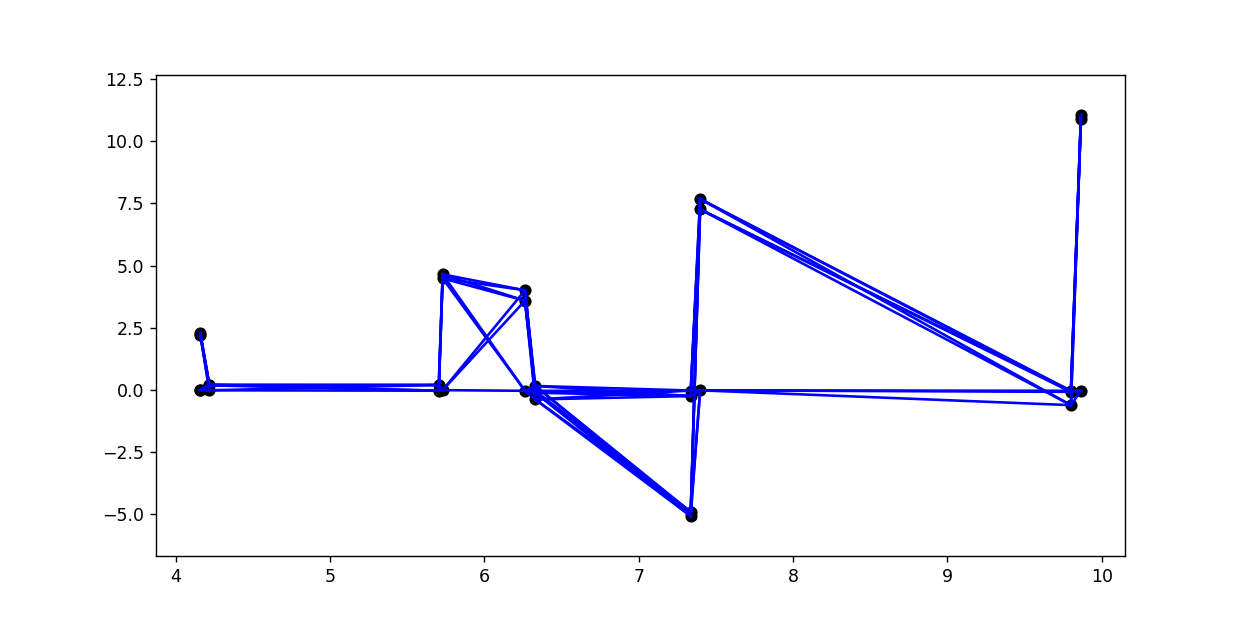

In [11]:
# read data and prepare for training
data = list(zip(*readMuonE()))
random.shuffle(data)
data_GNN, data_tracks, data_mc = zip(*data)

# split data into training and test datasets
split_index = int(0.8 * len(data_GNN))
train_dataset = data_GNN[:split_index]
test_dataset = data_GNN[split_index:]
data_tracks = data_tracks[split_index:]
data_mc = data_mc[split_index:]

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())
print("Training dataset (events): ", len(train_dataset))
print("Test dataset (events): ", len(test_dataset))

# display few events
for k in range(10):
    plot_2D_graph(train_loader.dataset[k])

In [12]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

In [13]:
weight = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"normalize_factor": 2000, "input_dim": 2, "hidden_node_dim": 128, "hidden_edge_dim": 256, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3, amsgrad=True)

In [14]:
EPOCHS = 500

start_time = time()
epoch_times = []

for epoch in range(EPOCHS):
    ep += 1
    
    epoch_start_time = time()
    
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    epoch_end_time = time()
    epoch_times.append(epoch_end_time - epoch_start_time)
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    remaining_time = avg_epoch_time * (EPOCHS - (epoch + 1))
    remaining_minutes, remaining_seconds = divmod(remaining_time, 60)
    
    print('Epoch: {}, Accuracy: {:.4f}, Time: {:.2f}s, Avg. Time/Epoch: {:.2f}s, Remaining Time: {:.0f}min:{:.0f}s'.format(
        ep, acc, epoch_end_time - epoch_start_time, avg_epoch_time, remaining_minutes, remaining_seconds))
    
end_time = time()
total_training_time = end_time - start_time
total_minutes, total_seconds = divmod(total_training_time, 60)
print('Total Training Time: {:.0f}min:{:.0f}s'.format(total_minutes, total_seconds))

Epoch: 1, Accuracy: 0.8512, Time: 27.33s, Avg. Time/Epoch: 27.33s, Remaining Time: 227min:16s
Epoch: 2, Accuracy: 0.8640, Time: 27.36s, Avg. Time/Epoch: 27.34s, Remaining Time: 226min:57s
Epoch: 3, Accuracy: 0.8629, Time: 27.85s, Avg. Time/Epoch: 27.51s, Remaining Time: 227min:53s
Epoch: 4, Accuracy: 0.8668, Time: 28.11s, Avg. Time/Epoch: 27.66s, Remaining Time: 228min:40s
Epoch: 5, Accuracy: 0.8687, Time: 28.18s, Avg. Time/Epoch: 27.76s, Remaining Time: 229min:3s
Epoch: 6, Accuracy: 0.8800, Time: 28.20s, Avg. Time/Epoch: 27.84s, Remaining Time: 229min:12s
Epoch: 7, Accuracy: 0.8640, Time: 28.24s, Avg. Time/Epoch: 27.89s, Remaining Time: 229min:12s
Epoch: 8, Accuracy: 0.8848, Time: 28.26s, Avg. Time/Epoch: 27.94s, Remaining Time: 229min:7s
Epoch: 9, Accuracy: 0.8775, Time: 28.28s, Avg. Time/Epoch: 27.98s, Remaining Time: 228min:57s
Epoch: 10, Accuracy: 0.8868, Time: 28.28s, Avg. Time/Epoch: 28.01s, Remaining Time: 228min:44s
Epoch: 11, Accuracy: 0.8827, Time: 28.29s, Avg. Time/Epoch: 2

<IPython.core.display.Javascript object>


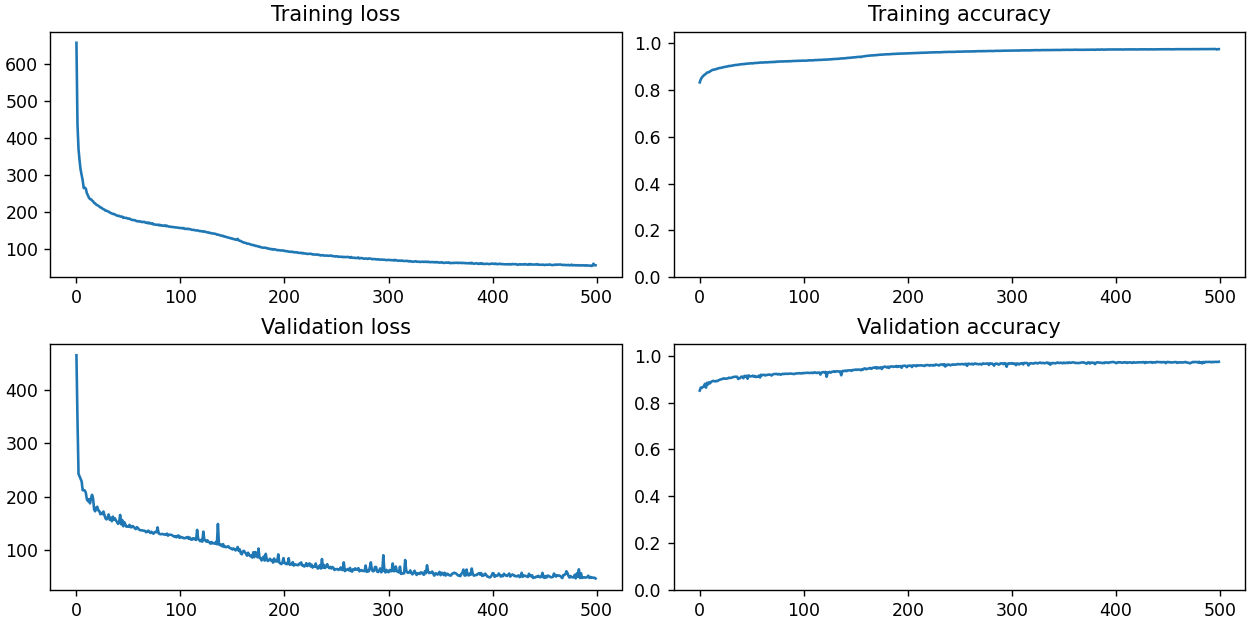

(0.0, 1.05)

In [15]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10, 5))

axs[0][0].plot(np.arange(len(t_loss_v)), t_loss_v)
axs[0][0].set_title("Training loss")
axs[0][0].set_yscale("linear")

axs[0][1].plot(np.arange(len(t_acc_v)), t_acc_v)
axs[0][1].set_title("Training accuracy")
axs[0][1].set_yscale("linear")
axs[0][1].set_ylim(0, 1.05)

axs[1][0].plot(np.arange(len(v_loss_v)), v_loss_v)
axs[1][0].set_title("Validation loss")
axs[1][0].set_yscale("linear")

axs[1][1].plot(np.arange(len(v_acc_v)), v_acc_v)
axs[1][1].set_title("Validation accuracy")
axs[1][1].set_yscale("linear")
axs[1][1].set_ylim(0, 1.05)

In [16]:
# save trained model
# torch.save(model.state_dict(), './GNN_real_data_factor_model.pth')

In [17]:
# load saved model
# model.load_state_dict(torch.load('./GNN_real_data_model.pth'))

<IPython.core.display.Javascript object>


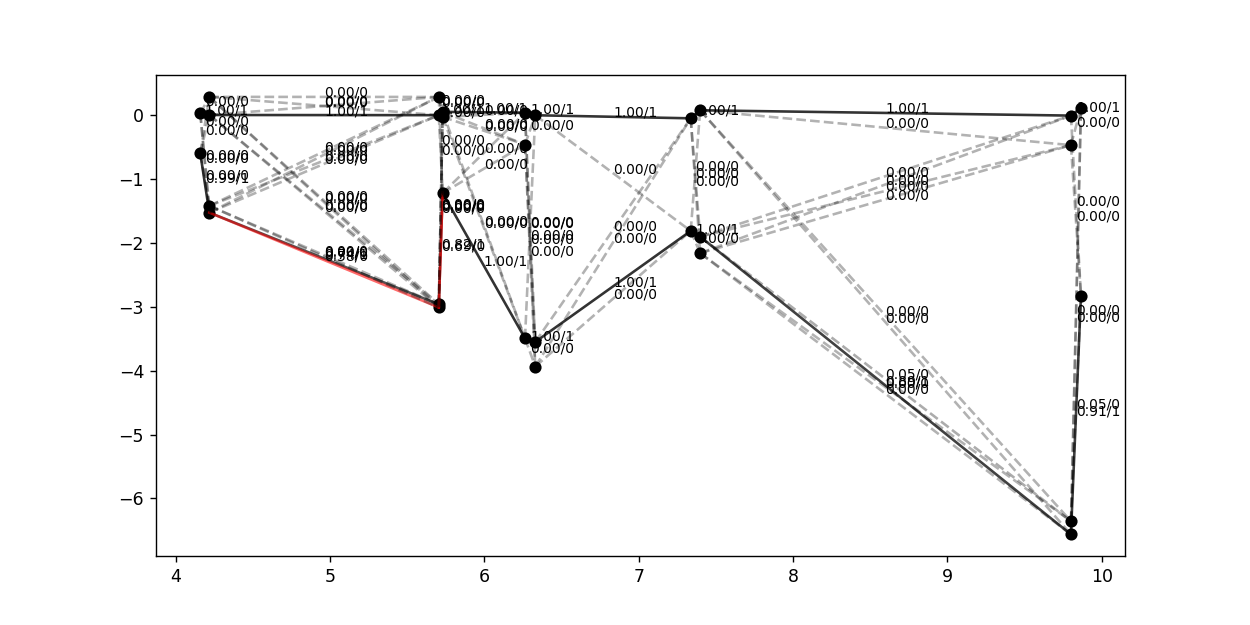

<IPython.core.display.Javascript object>


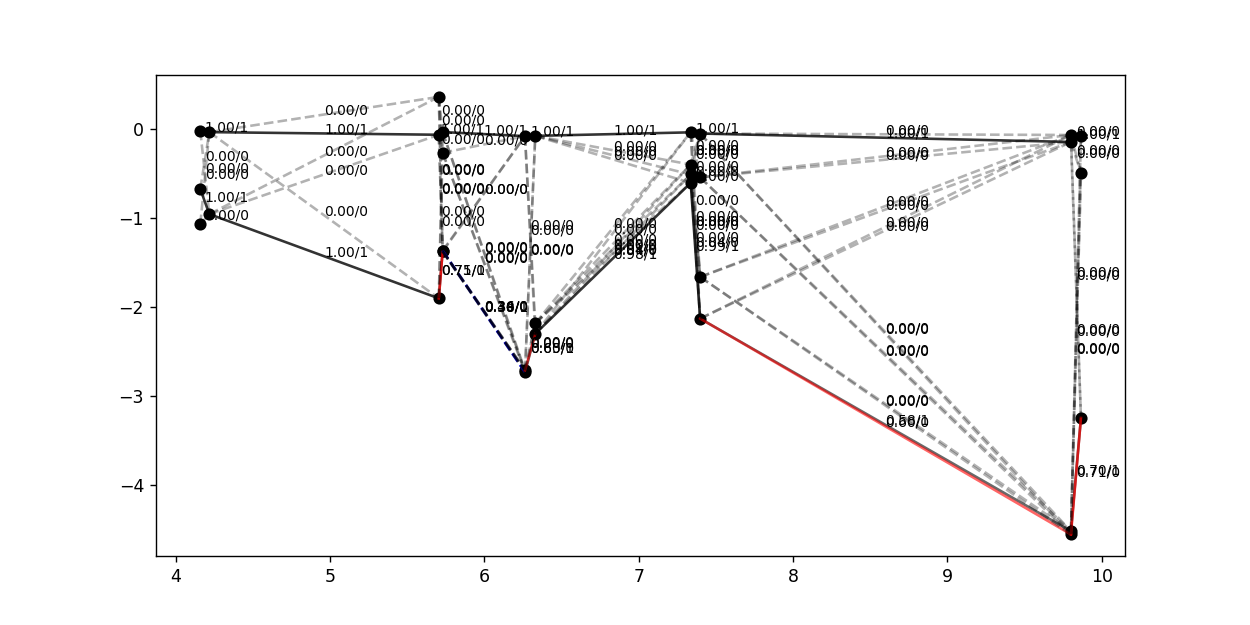

<IPython.core.display.Javascript object>


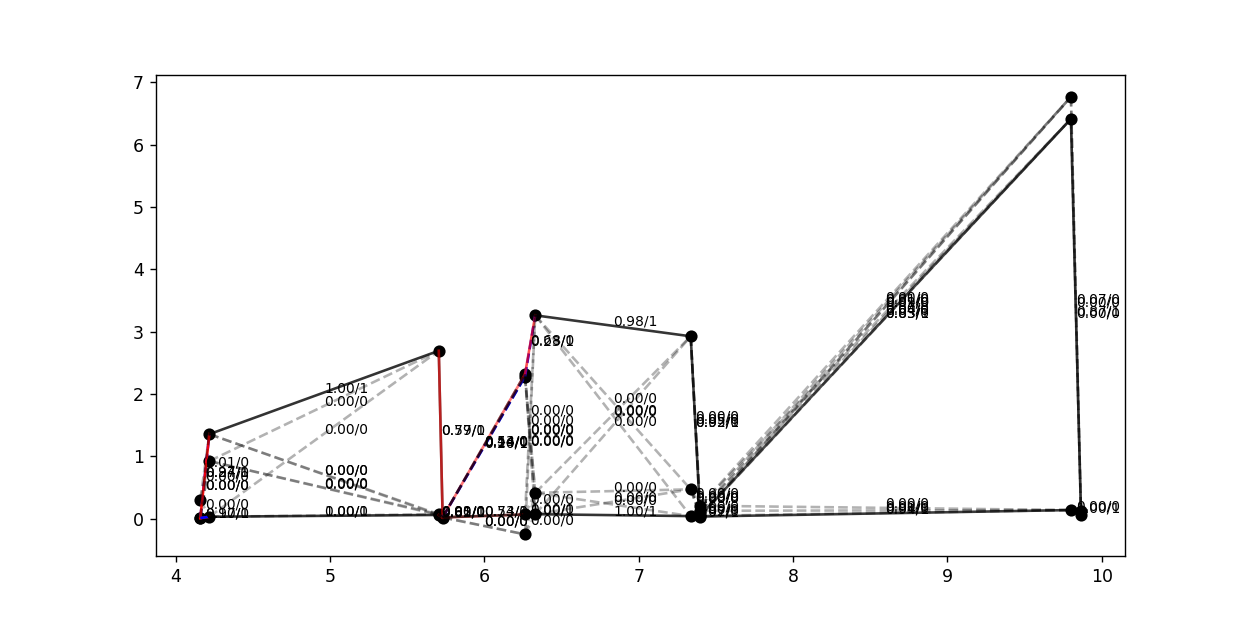

<IPython.core.display.Javascript object>


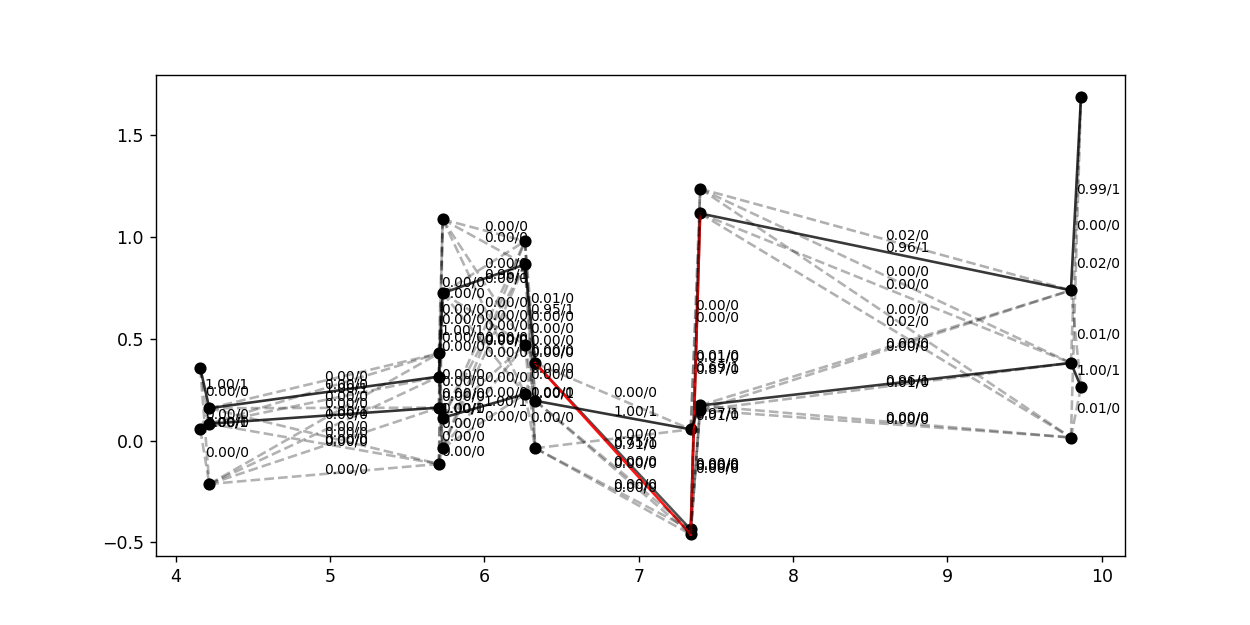

<IPython.core.display.Javascript object>


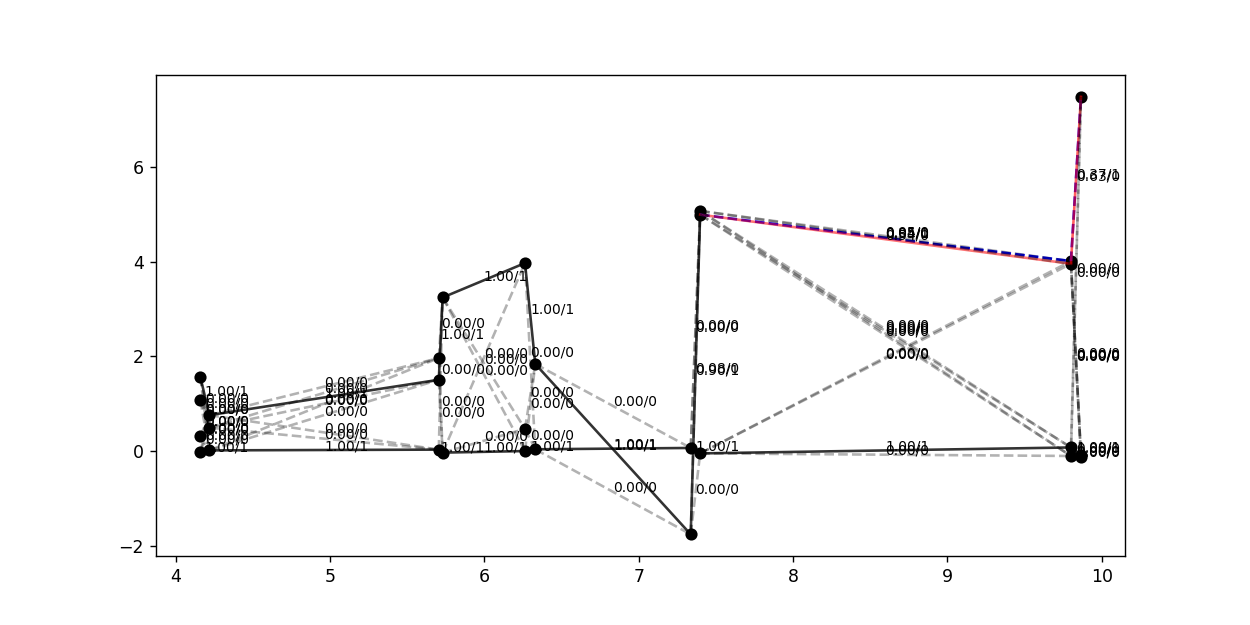

<IPython.core.display.Javascript object>


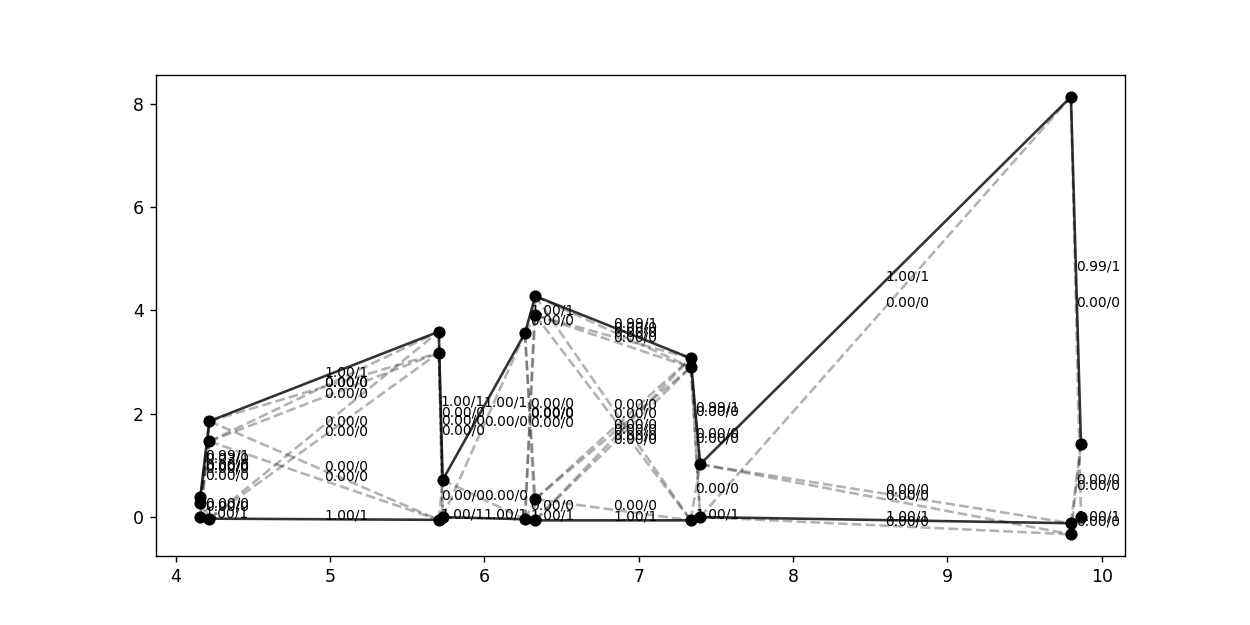

<IPython.core.display.Javascript object>


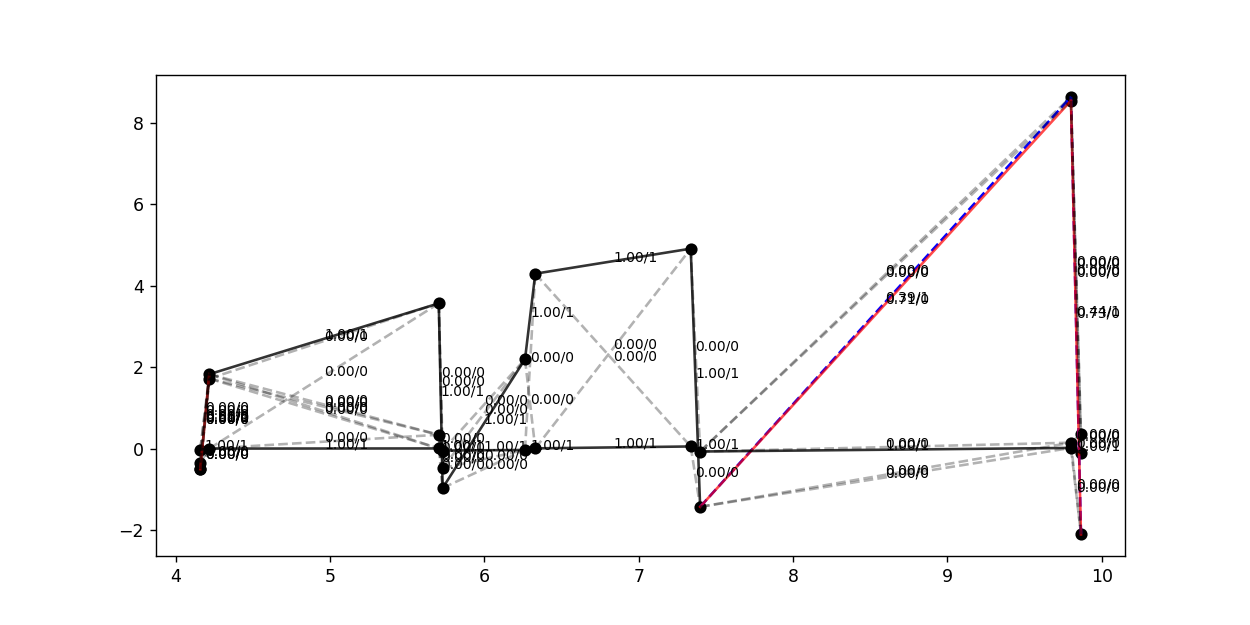

<IPython.core.display.Javascript object>


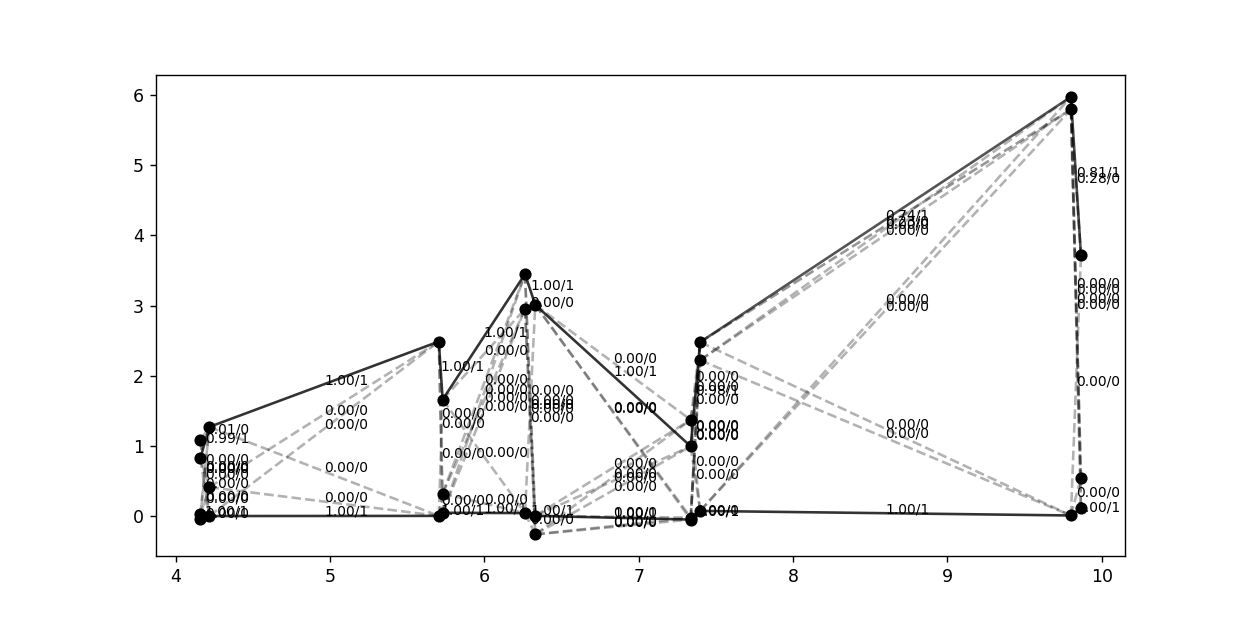

<IPython.core.display.Javascript object>


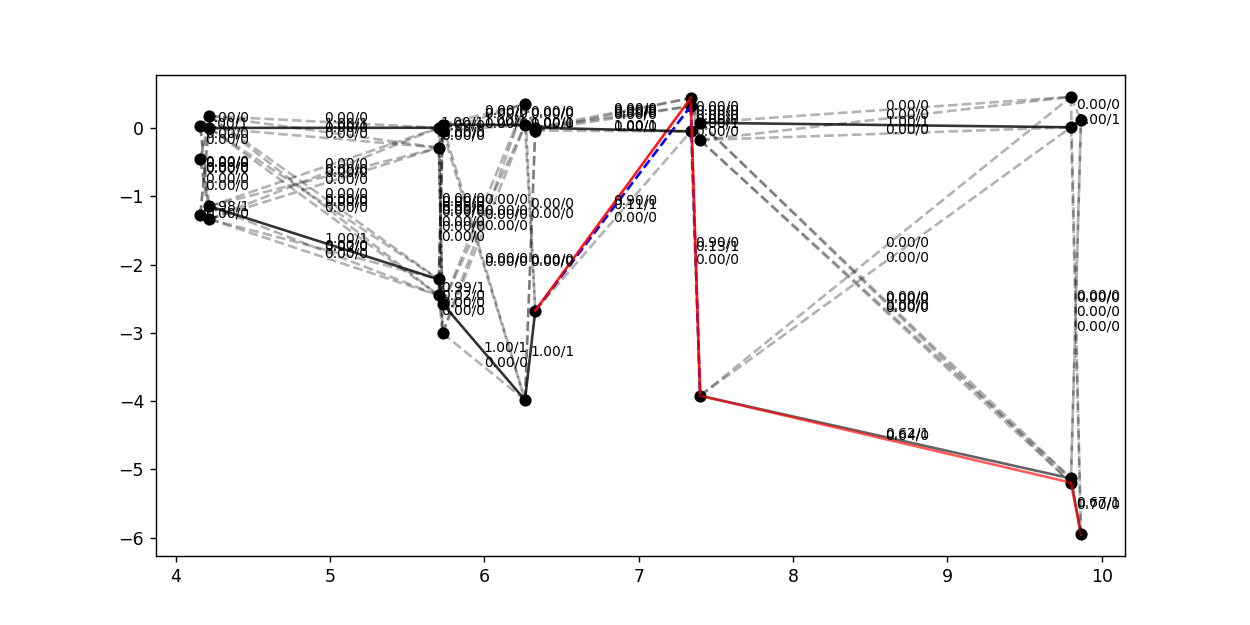

<IPython.core.display.Javascript object>


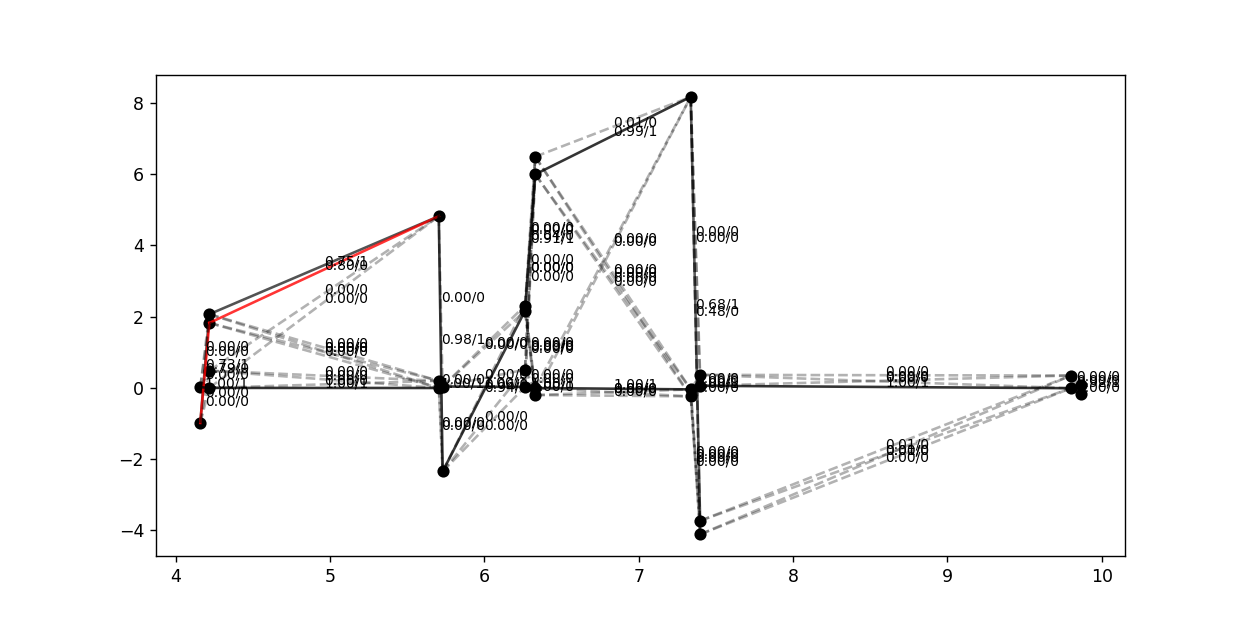

In [18]:
def plot_2D_classified(event, preds, cut=0.5):

#     print(event)
#     print(event.x)
#     print(event.pid)
#     print(event.y)
#     print(preds)

    plt.figure(figsize=(10,5))
    
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    preds = preds.detach().numpy()
    
    plt.scatter(x, y, c='k')

    for j in range(len(labels)):

        s = str('%01.2f' % preds[j]) + '/' + str(labels[j].item())
        plt.text((x[edges[0, j]] + x[edges[1, j]]) / 2.,
                 (y[edges[0, j]] + y[edges[1, j]]) / 2.,
                 s, fontsize=8)

        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=0.3 + 0.5*preds[j])

        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='k', alpha=0.3 + 0.5*preds[j])

# display few events            
for k in range(10):
    data = test_loader.dataset[k].to(device)
    preds = torch.sigmoid(model(data)).to('cpu')
    plot_2D_classified(data.to('cpu'), preds, cut = 0.5)

### Confusion matrix

<IPython.core.display.Javascript object>


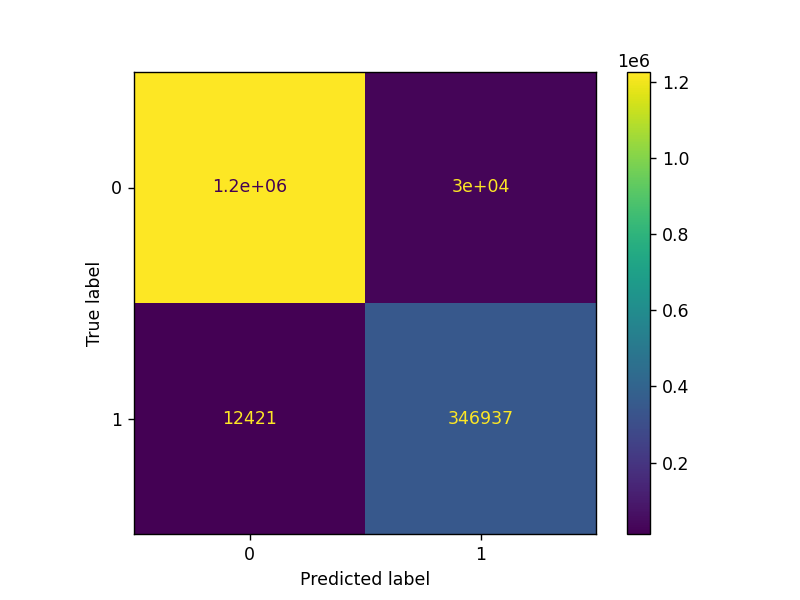

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# this makes out of memory error
# y_test = torch.cat([data.y.cpu() for data in test_loader.dataset])
# y_score = torch.cat([torch.sigmoid(model(data.to(device))) for data in test_loader.dataset]).cpu()
# y_pred = y_score > 0.5

y_test = torch.cat([data.y.cpu() for data in test_loader.dataset])
y_pred = torch.cat([torch.sigmoid(model(data.to(device))) > 0.5 for data in test_loader.dataset]).cpu()

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# fpr, tpr, _ = roc_curve(y_test, y_score.detach().numpy())
# RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# prec, recall, _ = precision_recall_curve(y_test, y_score.detach().numpy())
# PrecisionRecallDisplay(precision=prec, recall=recall).plot()